# Sentiment analysis on LLY event comparing the methods

Sentiment analysis on the Eli Lilly free insulin event on 11 November 2022, with a dataset from Mastodon. Using BERT trained with the IMDB training set, VADER and OpenAI davince as sentiment analysis models outputting continuous sentiment scores. In this document only sentiment analysis on the topics regarding Lilly will be executed, comparing BERT with VADER and OpenAI davinci.

Loading the Mastodon dataset.

In [1]:
import pickle

with open('../datasets/mastodon-lly.pkl','rb') as file:
    mastodon_dataframes = pickle.load(file)

## Sentiment analysis on Lilly

Creating the dataset with toots related to the topics 'Lilly', 'Eli Lilly', 'Eli Lilly and company' and 'LLY'.

In [2]:
import pandas as pd

df_lilly = pd.DataFrame(columns=['Date','ID','Content'])
lilly_topics = ['Lilly', 'Eli Lilly', 'Eli Lilly and company', 'LLY']

for topic in lilly_topics:
    df_lilly = pd.concat([df_lilly,mastodon_dataframes[topic]])

df_lilly.drop_duplicates(subset='ID',keep='first',inplace=True)
df_lilly = df_lilly.set_index('Date')

df_lilly.head(5)

,ID,Content
Date,,
2022-12-08 14:42:58,109478581359363509,"<p>ICYMI yesterday, our new <a href=""https://n..."
2022-12-05 17:58:35,109462365059484871,"<p><span class=""h-card""><a href=""https://roman..."
2022-12-01 20:33:41,109440324430339788,<p>Sophia has nursery toys Charlie and Lilly f...
2022-11-30 18:53:33,109434268151114981,<p>Eli Lilly CEO says insulin tweet flap “prob...
2022-11-28 03:01:05,109419198231109803,<p>Tickets acquired to see The Mountain Goats ...


Analyzing the content.

In [3]:
df_lilly['Content'][0]

'<p>ICYMI yesterday, our new <a href="https://newsie.social/tags/cardiovascular" class="mention hashtag" rel="nofollow noopener noreferrer" target="_blank">#<span>cardiovascular</span></a> reporter Elaine Chen reporting on the intersection of <a href="https://newsie.social/tags/obesity" class="mention hashtag" rel="nofollow noopener noreferrer" target="_blank">#<span>obesity</span></a> and <a href="https://newsie.social/tags/diabetes" class="mention hashtag" rel="nofollow noopener noreferrer" target="_blank">#<span>diabetes</span></a>: </p><p>the effects of constricting a drug for one condition that\'s prescribed off-label for another</p><p><a href="https://www.statnews.com/2022/12/07/eli-lilly-tightens-access-tirzepatide-mounjaro-diabetes-obesity/" rel="nofollow noopener noreferrer" target="_blank"><span class="invisible">https://www.</span><span class="ellipsis">statnews.com/2022/12/07/eli-li</span><span class="invisible">lly-tightens-access-tirzepatide-mounjaro-diabetes-obesity/</sp

Creating a function that cleans the content.

In [4]:
from bs4 import BeautifulSoup
import re

def clean_text(text):

    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[#@]', '', text)
    return text

df_lilly['Text'] = df_lilly['Content'].apply(clean_text)

df_lilly['Text'][0]

"ICYMI yesterday, our new cardiovascular reporter Elaine Chen reporting on the intersection of obesity and diabetes: the effects of constricting a drug for one condition that's prescribed off-label for another"

Converting the cleaned text to to the language BERT can interpret.

In [6]:
import torch
from transformers import DistilBertTokenizerFast
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification

model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

lilly_encodings = tokenizer(df_lilly['Text'].tolist(), truncation=True, padding=True, return_tensors='pt')

lilly = torch.utils.data.TensorDataset(lilly_encodings['input_ids'], lilly_encodings['attention_mask'])
lilly_dataloader = DataLoader(lilly, batch_size=16, shuffle=False)

Loading BERT that is trained on the normalized IMDB dataset from Stanford.

In [7]:
bert_model = torch.load('bert-imdb.pth')

Using BERT to perform sentiment analysis on the dataset.

In [8]:
bert_model.eval()
list_predicted_scores = []

with torch.no_grad():
    for batch in lilly_dataloader:
        input_ids, attention_mask = batch
        output = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        predicted_scores = output.logits.view(-1)

        list_predicted_scores.extend(predicted_scores.tolist())

df_lilly['BERT sentiment score'] = list_predicted_scores

df_lilly.head(5)

,ID,Content,Text,BERT sentiment score
Date,,,,
2022-12-08 14:42:58,109478581359363509,"<p>ICYMI yesterday, our new <a href=""https://n...","ICYMI yesterday, our new cardiovascular report...",0.339886
2022-12-05 17:58:35,109462365059484871,"<p><span class=""h-card""><a href=""https://roman...",skimgoth and water lillies?,0.025848
2022-12-01 20:33:41,109440324430339788,<p>Sophia has nursery toys Charlie and Lilly f...,Sophia has nursery toys Charlie and Lilly for ...,0.354358
2022-11-30 18:53:33,109434268151114981,<p>Eli Lilly CEO says insulin tweet flap “prob...,Eli Lilly CEO says insulin tweet flap “probabl...,-0.059616
2022-11-28 03:01:05,109419198231109803,<p>Tickets acquired to see The Mountain Goats ...,Tickets acquired to see The Mountain Goats and...,0.588035


### Analyzing the Lilly dataset.

First we will compute the distribution of the dates. This implies to how much toots there have been posted per time interval.

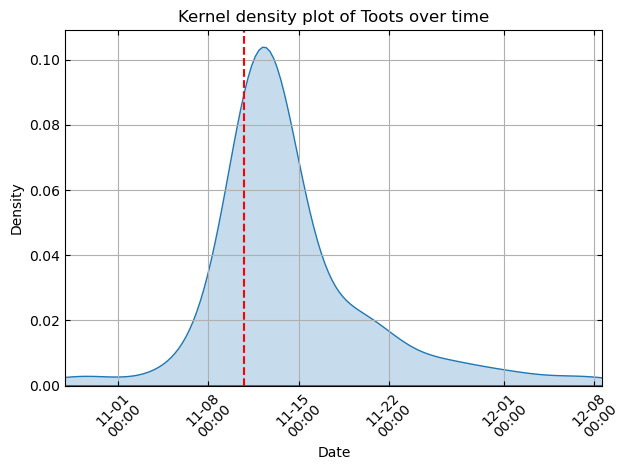

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

date_of_event = '2022-11-10 18:00'

sns.kdeplot(data=df_lilly.index, shade=True)

plt.tick_params(axis='both', direction='in',top=True, right=True)
plt.xlim(df_lilly.index.min(),df_lilly.index.max())

plt.xlabel('Date')
plt.title('Kernel density plot of Toots over time')

date_format = DateFormatter("%m-%d\n%H:%M")
plt.gca().xaxis.set_major_formatter(date_format)
plt.xticks(rotation=45)
plt.axvline(pd.to_datetime(date_of_event), color='red', linestyle='--')
plt.grid(True)

plt.tight_layout()
plt.show()

Secondly we will compute the summary statistics.

In [10]:
df_lilly_summary = pd.DataFrame({'min': df_lilly.min(numeric_only=True),
                                   'mean': df_lilly.mean(numeric_only=True),
                                   'median': df_lilly.median(numeric_only=True),
                                   'max': df_lilly.max(numeric_only=True)}).T

df_lilly_summary

,BERT sentiment score
min,-0.701116
mean,-0.034357
median,-0.059021
max,0.588035


Thirdly we will compute the distribution of the scores.

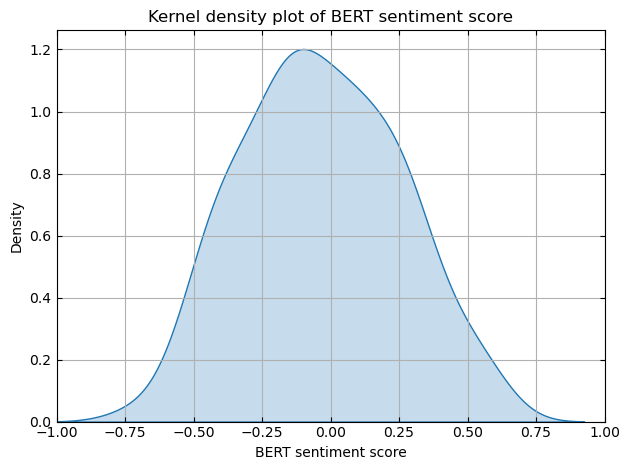

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(df_lilly['BERT sentiment score'], shade=True)

plt.tick_params(axis='both', direction='in',top=True, right=True)
plt.xlim(-1,1)
plt.title('Kernel density plot of BERT sentiment score')
plt.grid(True)

plt.tight_layout()
plt.show()

Lastly we will plot the sentiment scores against the date and we will compute the filtered mean.

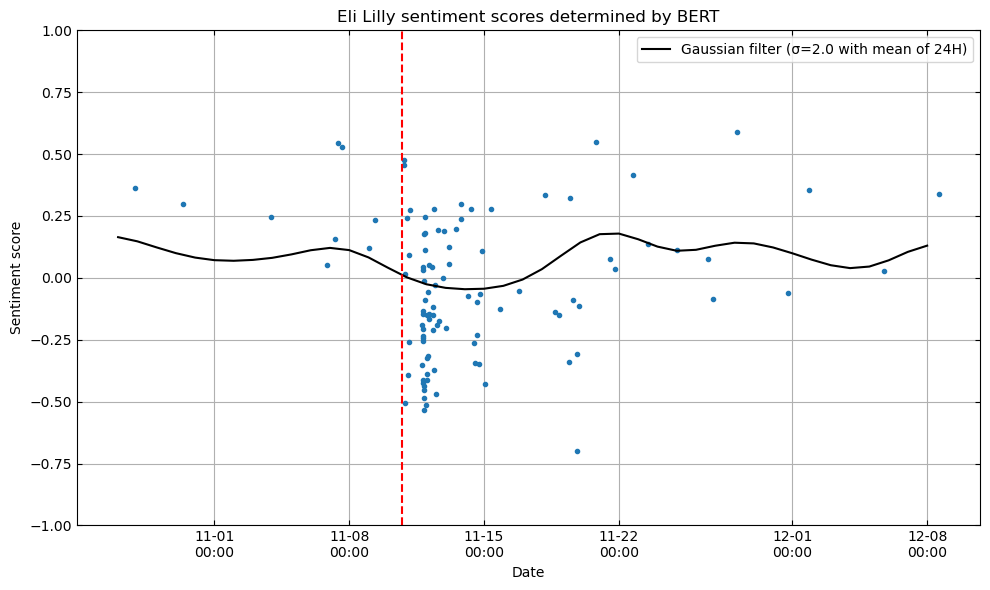

In [12]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

df_lilly_resampled = df_lilly[['BERT sentiment score']].resample('24H').mean().fillna(0)

sigma = 2.0
smoothed_scores = gaussian_filter1d(df_lilly_resampled['BERT sentiment score'], sigma=sigma)


plt.figure(figsize=(10,6))
plt.plot(df_lilly.index, df_lilly['BERT sentiment score'], marker='.', linestyle=' ')
plt.plot(df_lilly_resampled.index, smoothed_scores, color='black', label=f'Gaussian filter (σ={sigma} with mean of 24H)')
plt.ylim(-1,1)

plt.title('Eli Lilly sentiment scores determined by BERT')
plt.xlabel('Date')
plt.ylabel('Sentiment score')
plt.grid(True)

plt.tick_params(axis='both', direction='in',top=True, right=True)
#plt.xlim(df_lilly.index.min(),df_lilly.index.max())
plt.axvline(pd.to_datetime(date_of_event), color='red', linestyle='--')
plt.legend()

date_format = DateFormatter("%m-%d\n%H:%M")
plt.gca().xaxis.set_major_formatter(date_format)

plt.tight_layout()
plt.show()

Using VADER to perform sentiment analysis on the dataset.

In [13]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def vader_analyze_sentiment(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']

df_lilly['VADER sentiment score'] = df_lilly['Text'].apply(vader_analyze_sentiment)

df_lilly.head()

,ID,Content,Text,BERT sentiment score,VADER sentiment score
Date,,,,,
2022-12-08 14:42:58,109478581359363509,"<p>ICYMI yesterday, our new <a href=""https://n...","ICYMI yesterday, our new cardiovascular report...",0.339886,0.0000
2022-12-05 17:58:35,109462365059484871,"<p><span class=""h-card""><a href=""https://roman...",skimgoth and water lillies?,0.025848,0.0000
2022-12-01 20:33:41,109440324430339788,<p>Sophia has nursery toys Charlie and Lilly f...,Sophia has nursery toys Charlie and Lilly for ...,0.354358,0.0000
2022-11-30 18:53:33,109434268151114981,<p>Eli Lilly CEO says insulin tweet flap “prob...,Eli Lilly CEO says insulin tweet flap “probabl...,-0.059616,0.0000
2022-11-28 03:01:05,109419198231109803,<p>Tickets acquired to see The Mountain Goats ...,Tickets acquired to see The Mountain Goats and...,0.588035,0.3274


Computing the summary statistics.

In [14]:
df_lilly_summary = pd.DataFrame({'min': df_lilly.min(numeric_only=True),
                                   'mean': df_lilly.mean(numeric_only=True),
                                   'median': df_lilly.median(numeric_only=True),
                                   'max': df_lilly.max(numeric_only=True)}).T

df_lilly_summary

,BERT sentiment score,VADER sentiment score
min,-0.701116,-0.95770
mean,-0.034357,0.03114
median,-0.059021,0.00000
max,0.588035,0.92940


Computing the distribution of the scores.

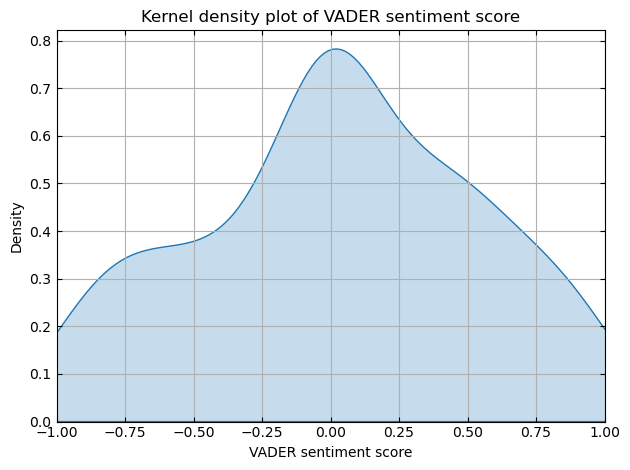

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(df_lilly['VADER sentiment score'], shade=True)

plt.tick_params(axis='both', direction='in',top=True, right=True)
plt.xlim(-1,1)
plt.title('Kernel density plot of VADER sentiment score')
plt.grid(True)

plt.tight_layout()
plt.show()

Lastly we will plot the sentiment scores against the date and we will compute the filtered mean.

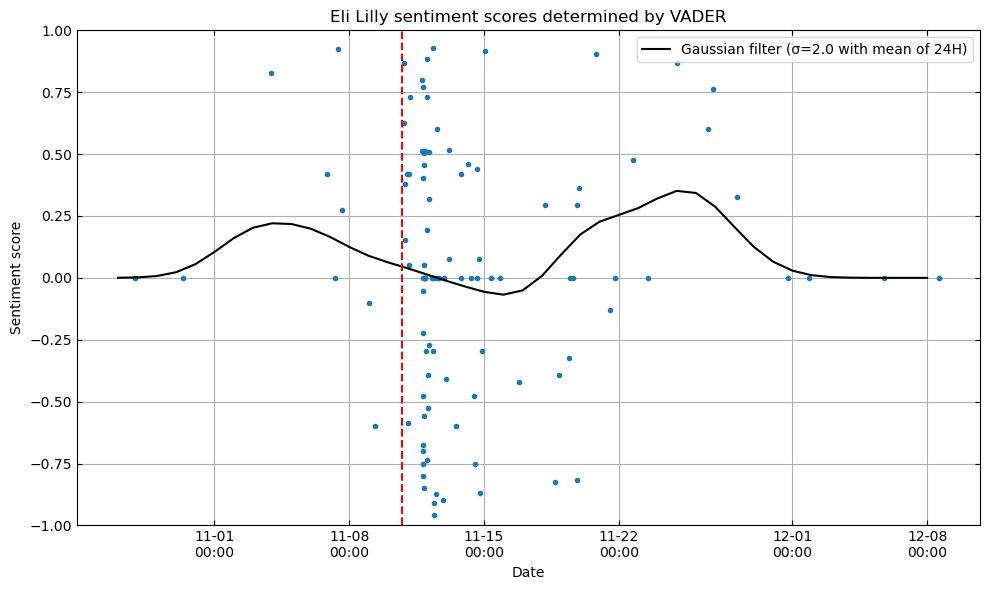

In [16]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

df_lilly_resampled = df_lilly[['VADER sentiment score']].resample('24H').mean().fillna(0)

sigma = 2.0
smoothed_scores = gaussian_filter1d(df_lilly_resampled['VADER sentiment score'], sigma=sigma)


plt.figure(figsize=(10,6))
plt.plot(df_lilly.index, df_lilly['VADER sentiment score'], marker='.', linestyle=' ')
plt.plot(df_lilly_resampled.index, smoothed_scores, color='black', label=f'Gaussian filter (σ={sigma} with mean of 24H)')
plt.ylim(-1,1)

plt.title('Eli Lilly sentiment scores determined by VADER')
plt.xlabel('Date')
plt.ylabel('Sentiment score')
plt.grid(True)

plt.tick_params(axis='both', direction='in',top=True, right=True)
#plt.xlim(df_lilly.index.min(),df_lilly.index.max())
plt.axvline(pd.to_datetime(date_of_event), color='red', linestyle='--')
plt.legend()

date_format = DateFormatter("%m-%d\n%H:%M")
plt.gca().xaxis.set_major_formatter(date_format)

plt.tight_layout()
plt.show()

Using openAI davinci to perform sentiment analysis on the dataset.

In [17]:
import openai

openai_key = None

with open("../.credentials", "r") as file:
    for line in file:
        if 'openai-key' in line:
            openai_key = line.split('openai-key=')[1].strip()
            break

if openai_key is not None:
    openai.api_key = openai_key
else:
    print('Could not retrieve openAI key, do you have it in your credentials file?')\

def openai_analyze_sentiment(text):
    response = openai.Completion.create(
        engine="text-davinci-002",
        prompt=f"Please provide only a sentiment score between -1 (most negative) and 1 (most positive) for the following text: '{text}'",
        temperature=0.5,
        max_tokens=10
    )
    
    sentiment_score_match = re.search(r'-?\d+(\.\d+)?', response.choices[0].text)
    
    if sentiment_score_match:
        sentiment_score = float(sentiment_score_match.group())

        if sentiment_score >= -1 and sentiment_score <= 1:
            return sentiment_score
        else:
            return None

    else:
         return None

df_lilly['OpenAI sentiment score'] = df_lilly['Text'].apply(openai_analyze_sentiment)

df_lilly.head()

,ID,Content,Text,BERT sentiment score,VADER sentiment score,OpenAI sentiment score
Date,,,,,,
2022-12-08 14:42:58,109478581359363509,"<p>ICYMI yesterday, our new <a href=""https://n...","ICYMI yesterday, our new cardiovascular report...",0.339886,0.0000,0.0
2022-12-05 17:58:35,109462365059484871,"<p><span class=""h-card""><a href=""https://roman...",skimgoth and water lillies?,0.025848,0.0000,0.0
2022-12-01 20:33:41,109440324430339788,<p>Sophia has nursery toys Charlie and Lilly f...,Sophia has nursery toys Charlie and Lilly for ...,0.354358,0.0000,1.0
2022-11-30 18:53:33,109434268151114981,<p>Eli Lilly CEO says insulin tweet flap “prob...,Eli Lilly CEO says insulin tweet flap “probabl...,-0.059616,0.0000,1.0
2022-11-28 03:01:05,109419198231109803,<p>Tickets acquired to see The Mountain Goats ...,Tickets acquired to see The Mountain Goats and...,0.588035,0.3274,1.0


Computing the summary statistics.

In [18]:
df_lilly_summary = pd.DataFrame({'min': df_lilly.min(numeric_only=True),
                                   'mean': df_lilly.mean(numeric_only=True),
                                   'median': df_lilly.median(numeric_only=True),
                                   'max': df_lilly.max(numeric_only=True)}).T

df_lilly_summary

,BERT sentiment score,VADER sentiment score,OpenAI sentiment score
min,-0.701116,-0.95770,-1.000000
mean,-0.034357,0.03114,0.187629
median,-0.059021,0.00000,0.000000
max,0.588035,0.92940,1.000000


Computing the distribution of the scores.

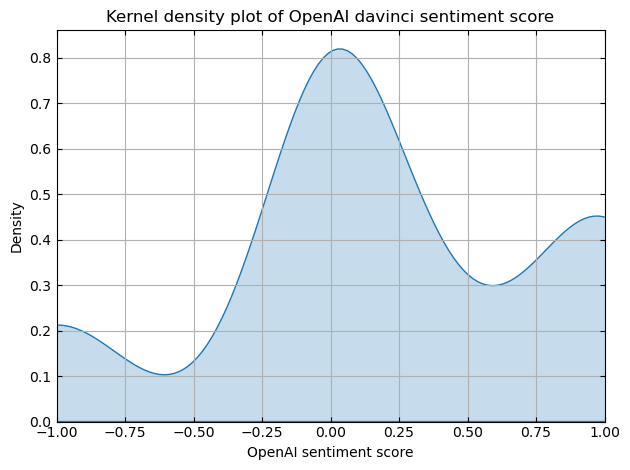

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(df_lilly['OpenAI sentiment score'], shade=True)

plt.tick_params(axis='both', direction='in',top=True, right=True)
plt.xlim(-1,1)
plt.title('Kernel density plot of OpenAI davinci sentiment score')
plt.grid(True)

plt.tight_layout()
plt.show()

Lastly we will plot the sentiment scores against the date and we will compute the filtered mean.

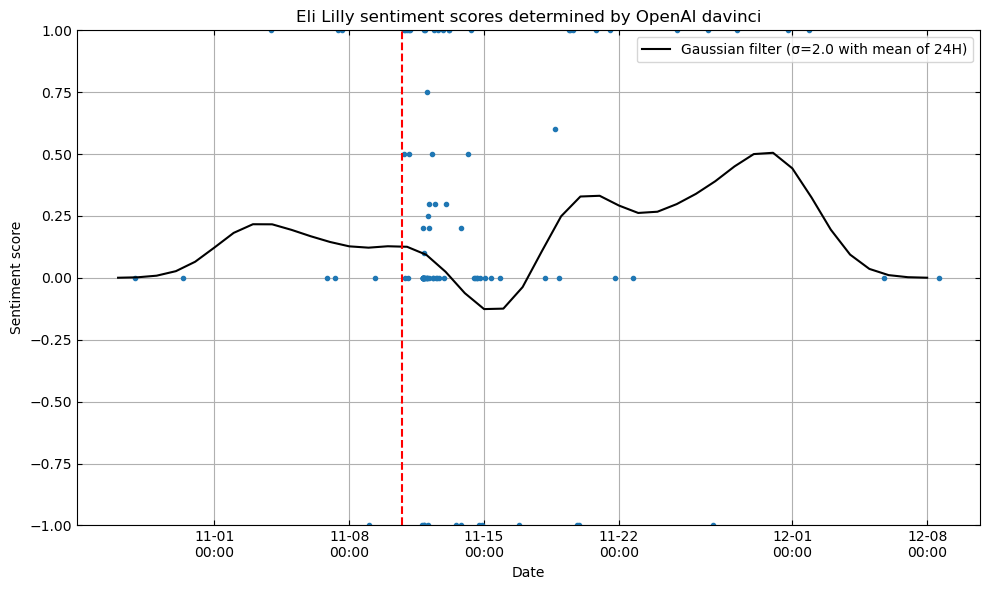

In [20]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

df_lilly_resampled = df_lilly[['OpenAI sentiment score']].resample('24H').mean().fillna(0)

sigma = 2.0
smoothed_scores = gaussian_filter1d(df_lilly_resampled['OpenAI sentiment score'], sigma=sigma)


plt.figure(figsize=(10,6))
plt.plot(df_lilly.index, df_lilly['OpenAI sentiment score'], marker='.', linestyle=' ')
plt.plot(df_lilly_resampled.index, smoothed_scores, color='black', label=f'Gaussian filter (σ={sigma} with mean of 24H)')
plt.ylim(-1,1)

plt.title('Eli Lilly sentiment scores determined by OpenAI davinci')
plt.xlabel('Date')
plt.ylabel('Sentiment score')
plt.grid(True)

plt.tick_params(axis='both', direction='in',top=True, right=True)
#plt.xlim(df_lilly.index.min(),df_lilly.index.max())
plt.axvline(pd.to_datetime(date_of_event), color='red', linestyle='--')
plt.legend()

date_format = DateFormatter("%m-%d\n%H:%M")
plt.gca().xaxis.set_major_formatter(date_format)

plt.tight_layout()
plt.show()